In [1]:
suppressPackageStartupMessages({
    library("dplyr")
    library("Matrix")
    library("Seurat")
    library("SeuratWrappers")
    library("tictoc")
    library("ggplot2")
    library("ggpubr")
    library("future")
    library("SingleR")
    library("scRNAseq")
    library("pheatmap")
})

In [2]:
tic()
load("./PP1_data/ABMaLP2_PP1.rda")
toc()

19.352 sec elapsed


In [84]:
tic()
ref       <- ImmGenData()
mat       <- GetAssayData(seu, slot="data")
pred.immgen.fine <- SingleR(test = mat, ref = ref, labels = ref$label.fine)
pred.immgen.main <- SingleR(test = mat, ref = ref, labels = ref$label.main)

seu[["pred.immgen.fine"]]      <-pred.immgen.fine$labels
seu[["pred.immgen.finepruned"]]<-pred.immgen.fine$pruned.labels

seu[["pred.immgen.main"]]      <-pred.immgen.main$labels
seu[["pred.immgen.mainpruned"]]<-pred.immgen.main$pruned.labels
toc()

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache

snapshotDate(): 2019-10-22

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache

see ?SingleR and browseVignettes('SingleR') for documentation

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache

loading from cache

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache

see ?SingleR and browseVignettes('SingleR') for documentation

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache

loading from cache

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache

Using temporary cache /tmp/RtmpbiVRpg/BiocFileCache



1017.653 sec elapsed


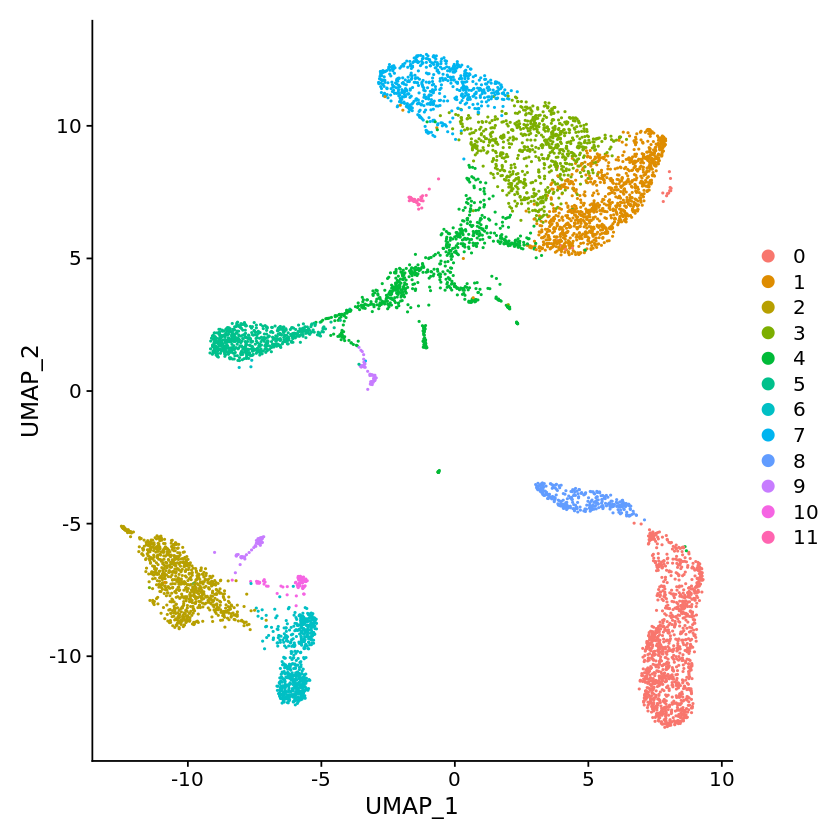

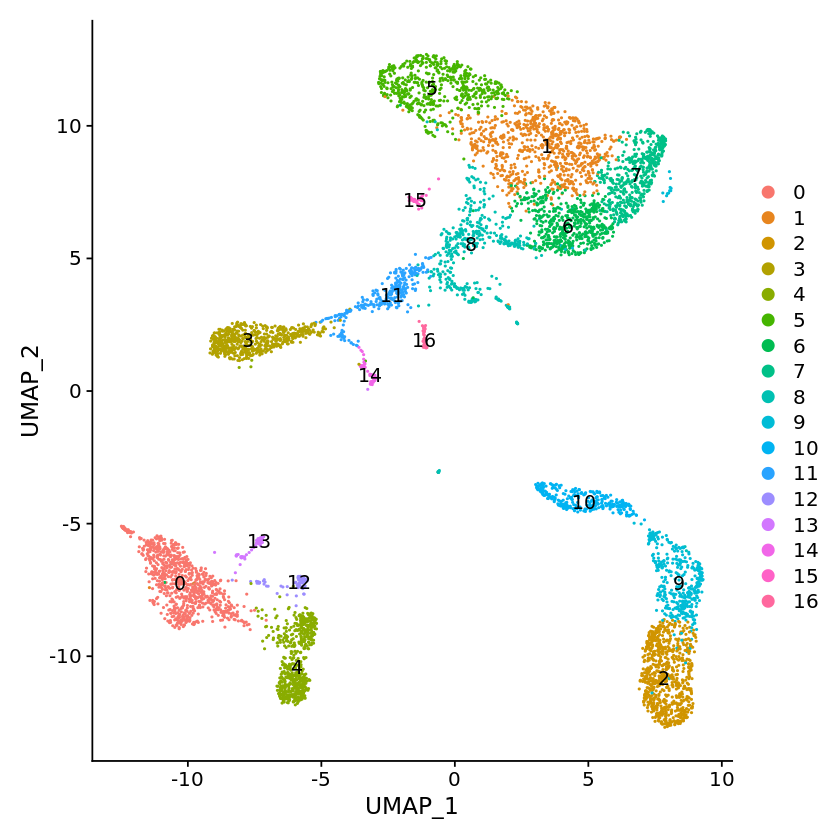

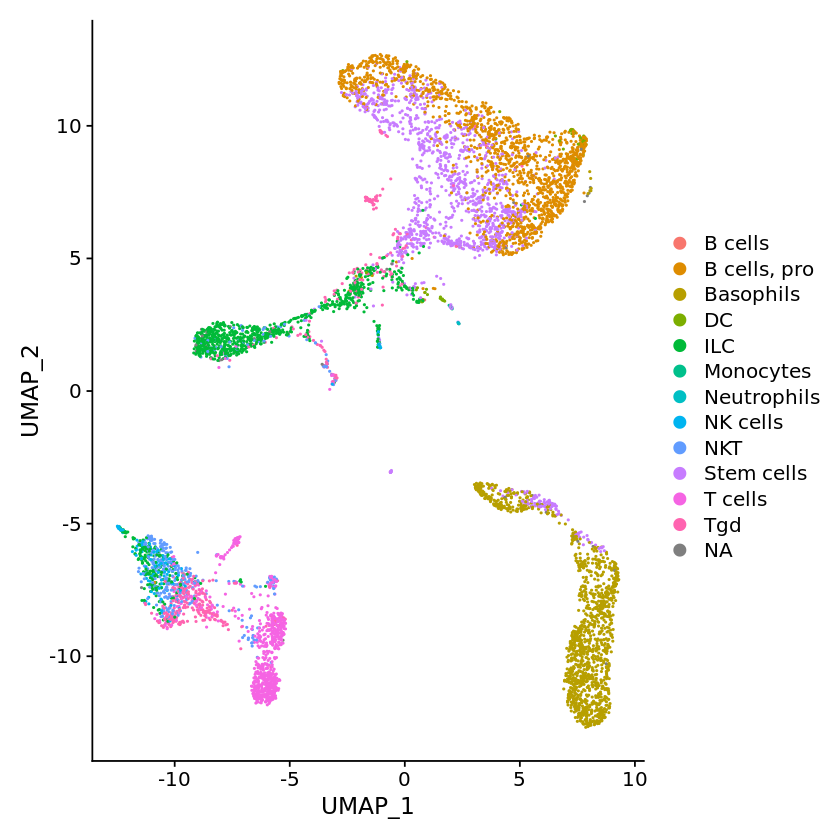

In [85]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(seu, group.by="RNA_snn_res.0.3")
DimPlot(seu, group.by="RNA_snn_res.0.5", label=T)
DimPlot(seu, group.by="pred.immgen.mainpruned")

In [86]:
seu->seu.all

# note that cell clusters that are of interests under RNA_snn_res.0.5
# c(1,3,5,6,7,8,11,14,15,16)

In [21]:
Idents(seu)<-"RNA_snn_res.0.5"
tic("DE")
markers <- FindAllMarkers(seu, only.pos = FALSE, min.pct = 0.25, 
                          logfc.threshold = 0.25, return.thresh = 0.01)
toc()


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16



DE: 1037.213 sec elapsed


In [22]:
# Filter
markers <- markers[ markers$p_val_adj<0.01, ]
# Sort
markers <- markers[ order(markers$cluster, -markers$avg_logFC), ]

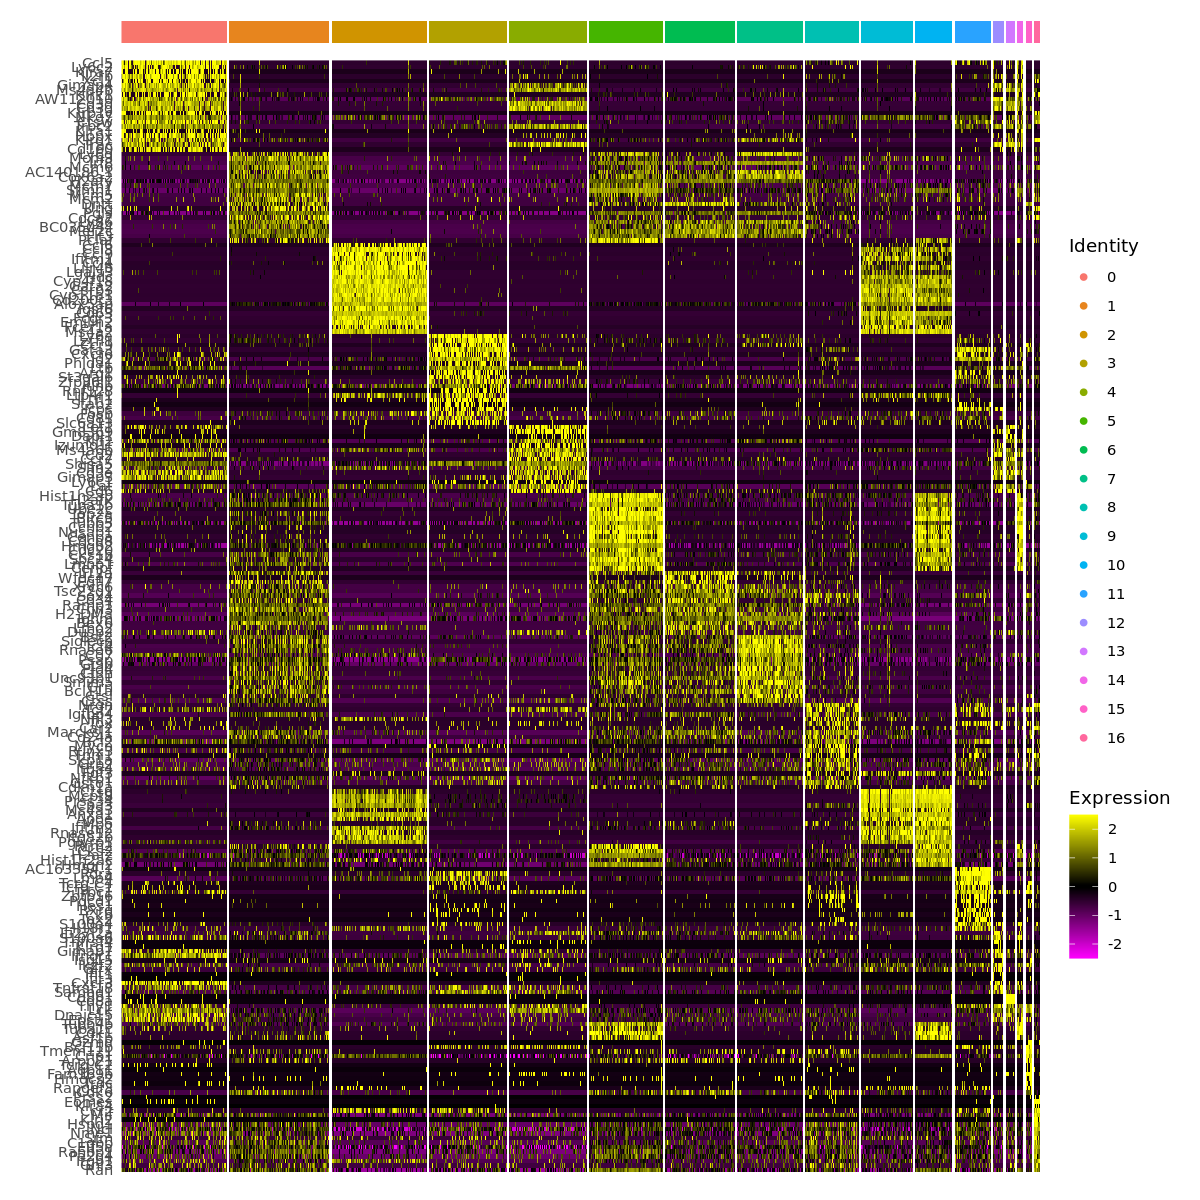

In [26]:
# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=10)
DoHeatmap(seu, features = markers.top$gene, label=F)

In [ ]:
seu0<-subset(seu, RNA_snn_res.0.5==0)
markers.top[ markers.top$cluster==, ]

In [33]:
cluster_names <- unique(sort(seu@meta.data$"RNA_snn_res.0.5"))
seu_subsets <-list()
for (cluster in cluster_names){
    cluster<-as.character(cluster)
    seu_subsets[[cluster]]<-subset(seu, RNA_snn_res.0.5==cluster)
}

In [88]:
putative_doublets<-c()

# C1

In [91]:
seu <- seu_subsets[["1"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["1"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 7.256 sec elapsed


Computing nearest neighbor graph

Computing SNN



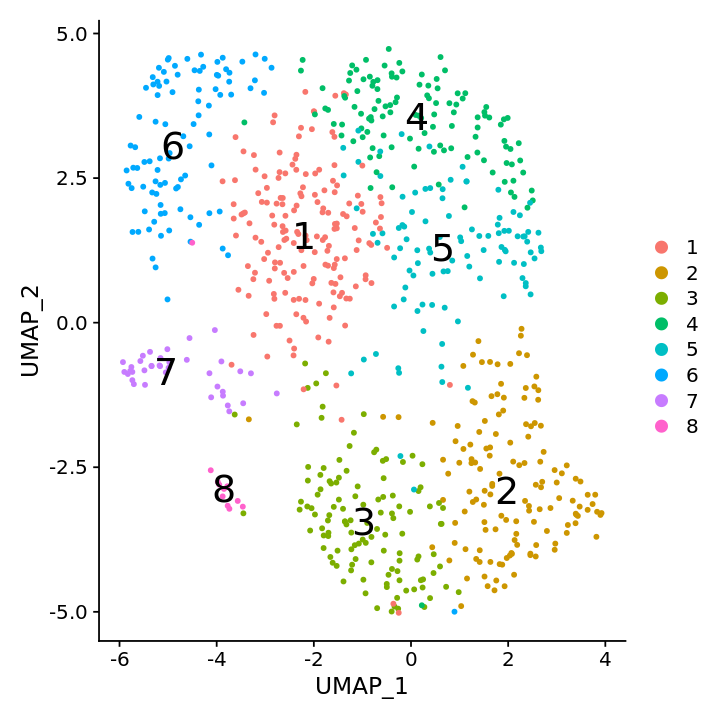

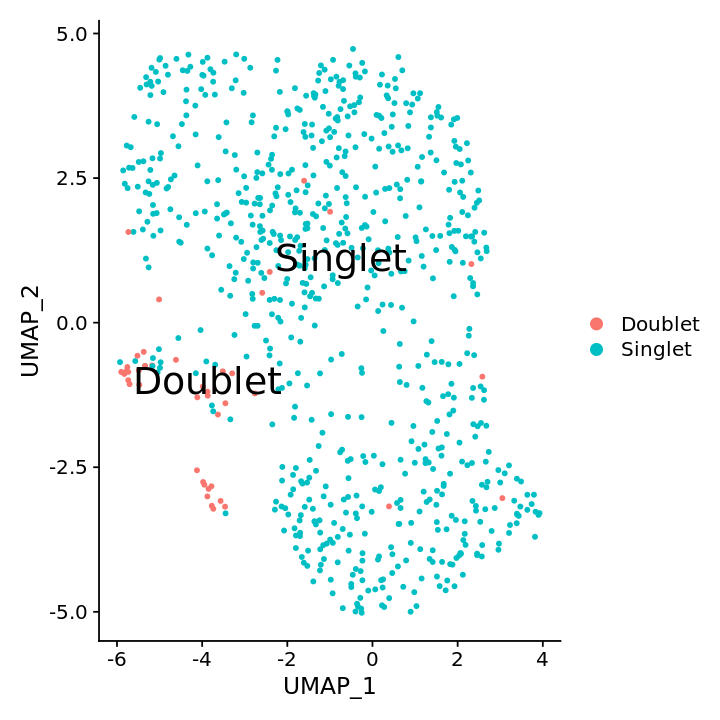

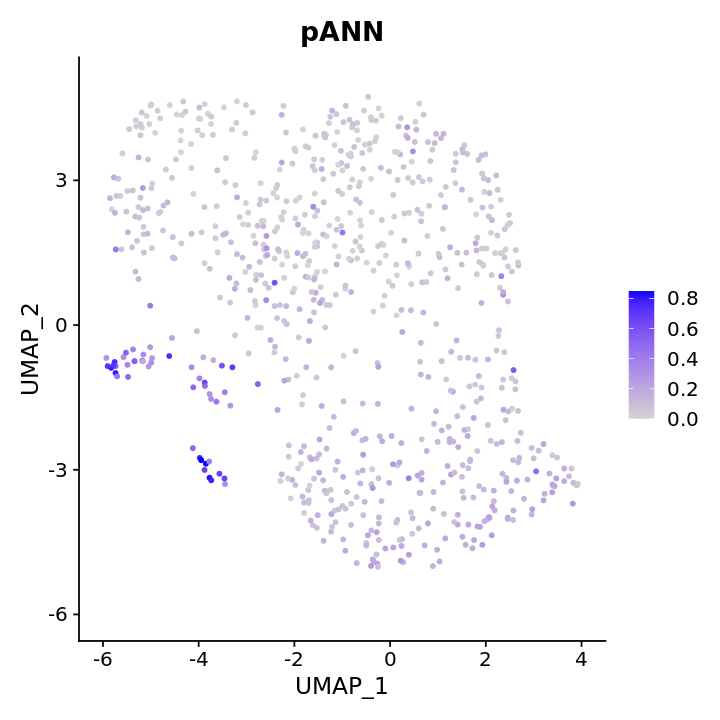

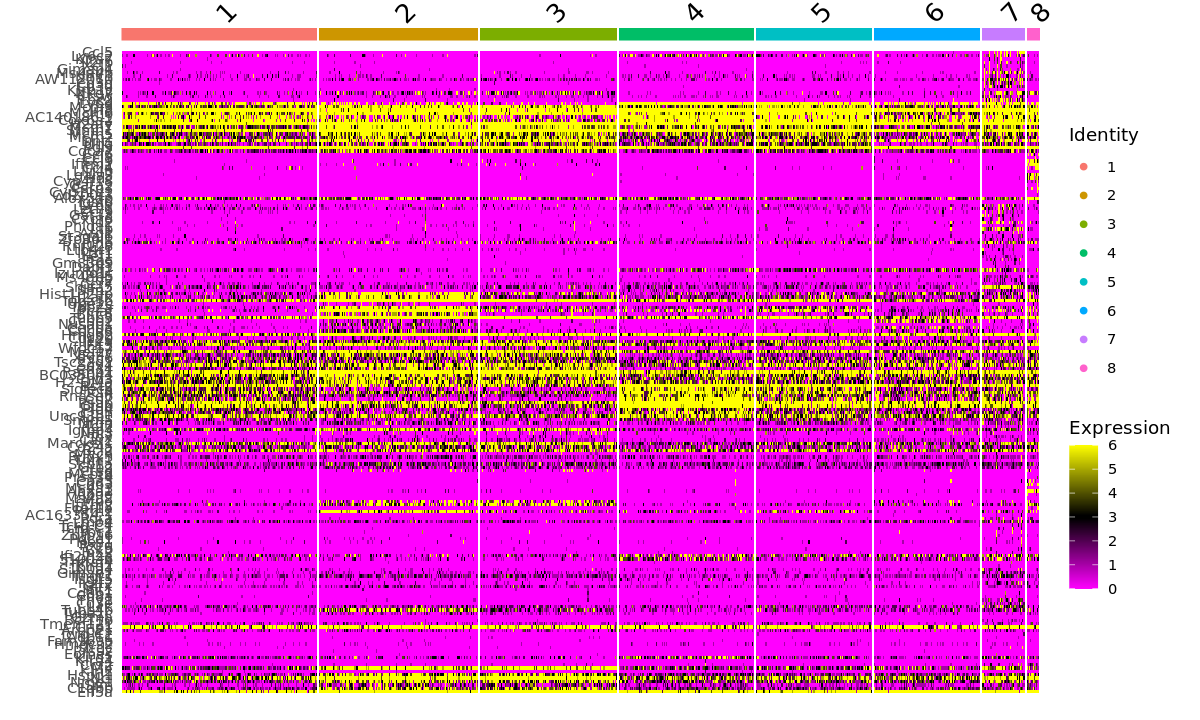

In [92]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [98]:
barcodes<-colnames(subset(seu, leiden_res.0.7=="7"|leiden_res.0.7=="8"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C3

In [99]:
seu <- seu_subsets[["3"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["3"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 5.482 sec elapsed


Computing nearest neighbor graph

Computing SNN



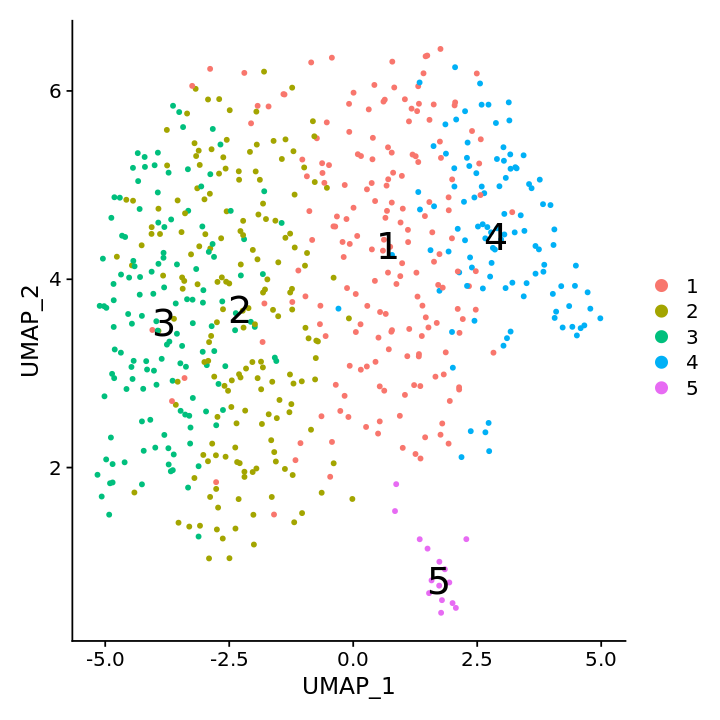

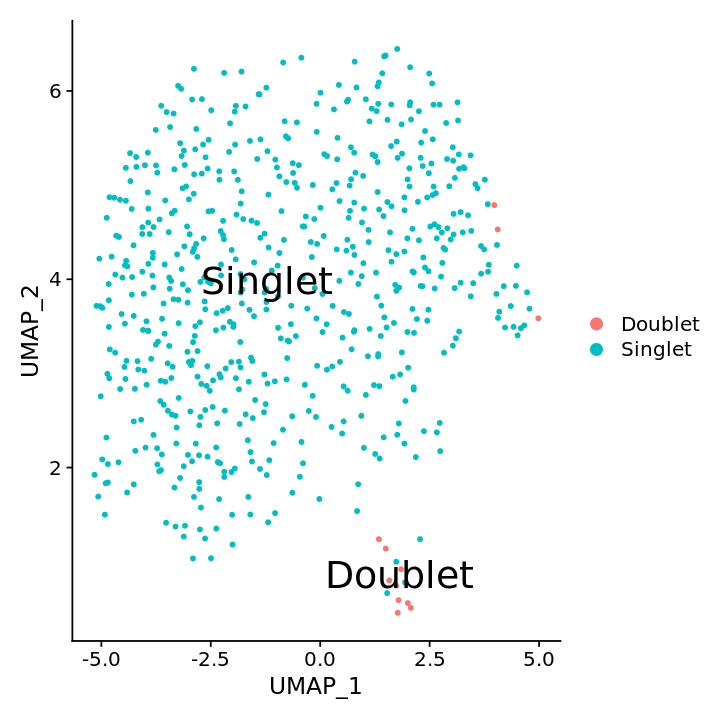

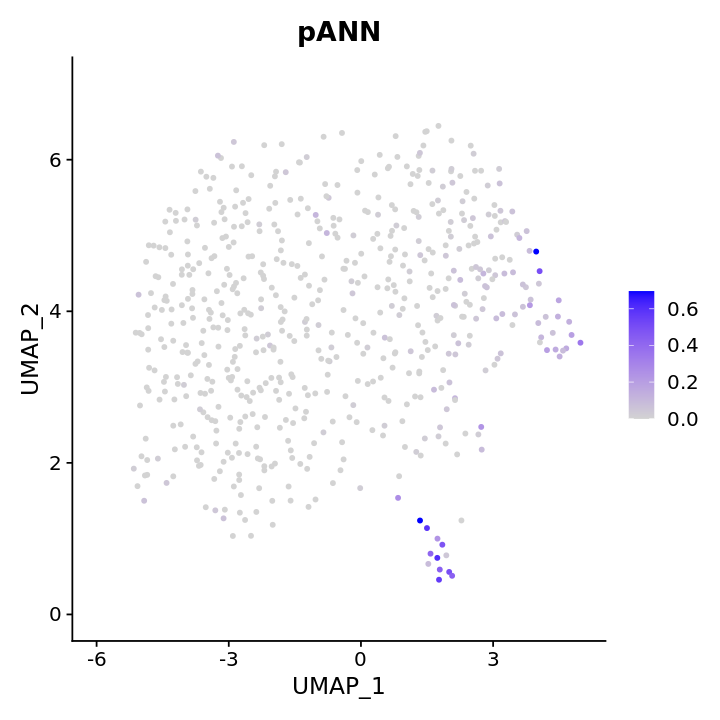

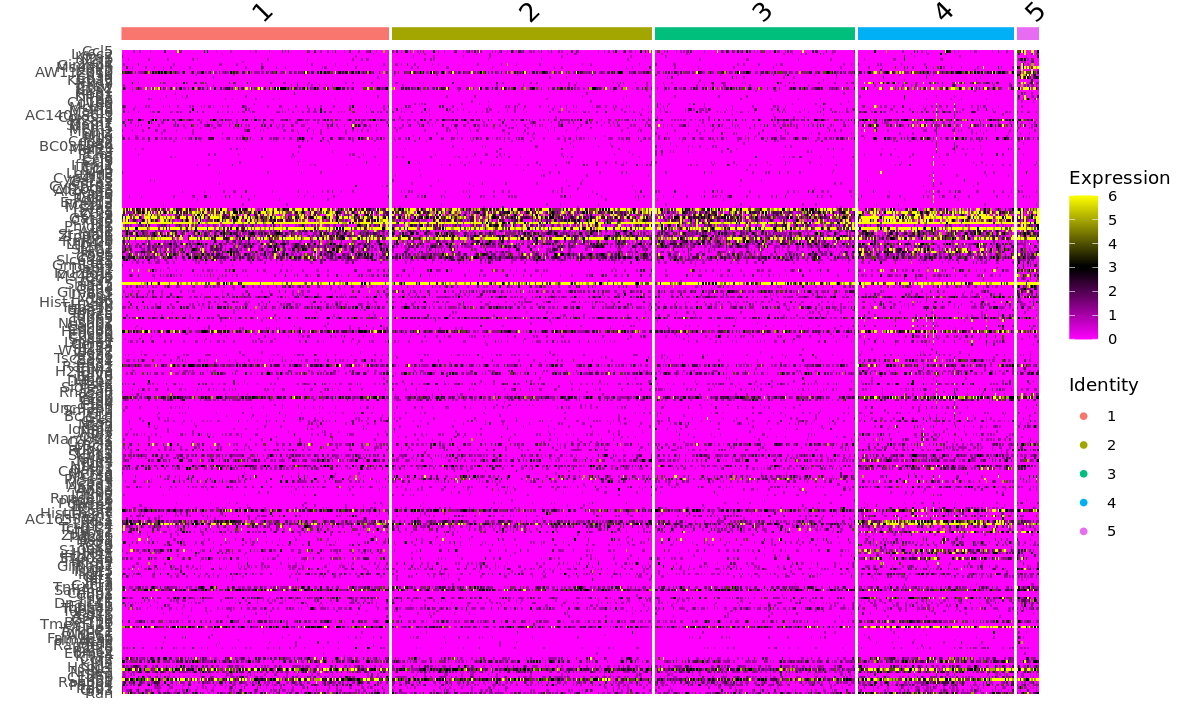

In [101]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [102]:
barcodes<-colnames(subset(seu, leiden_res.0.7=="5"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C5

In [104]:
seu <- seu_subsets[["5"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["5"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 5.607 sec elapsed


Computing nearest neighbor graph

Computing SNN



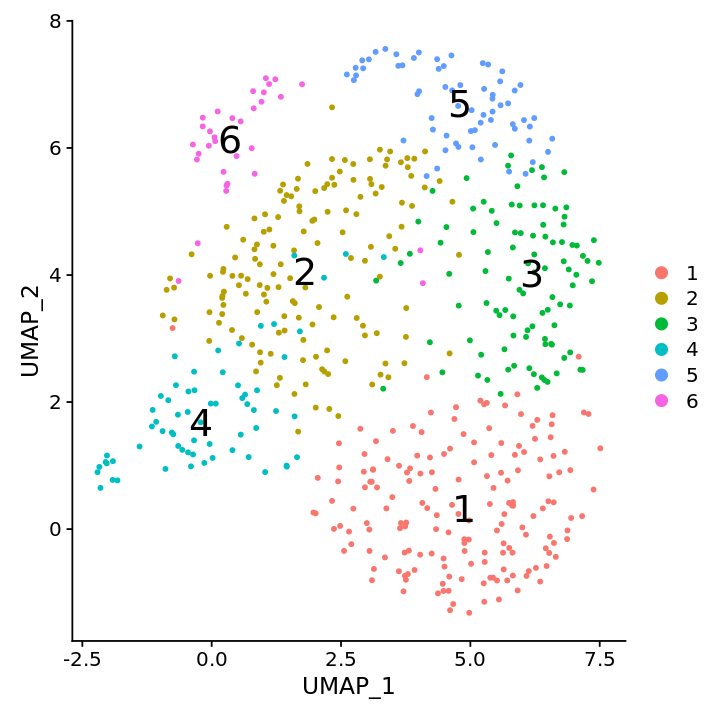

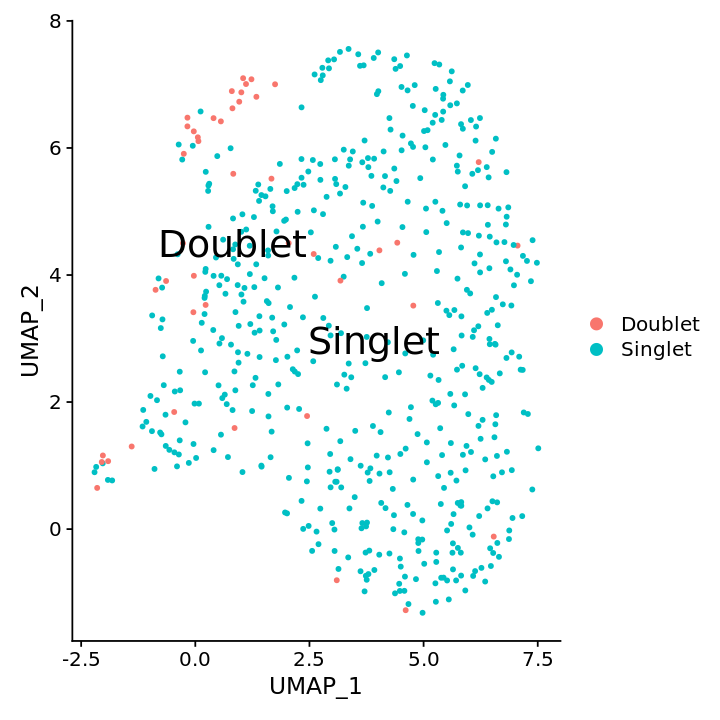

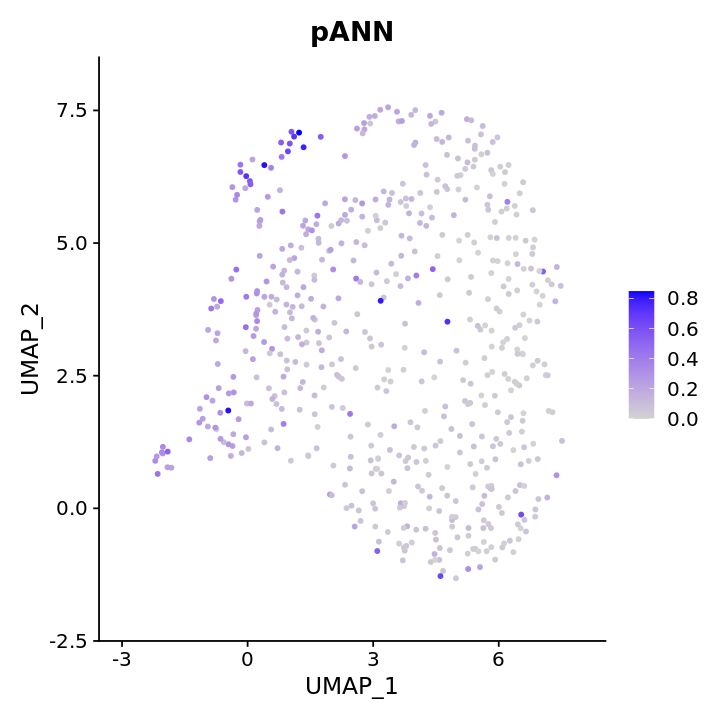

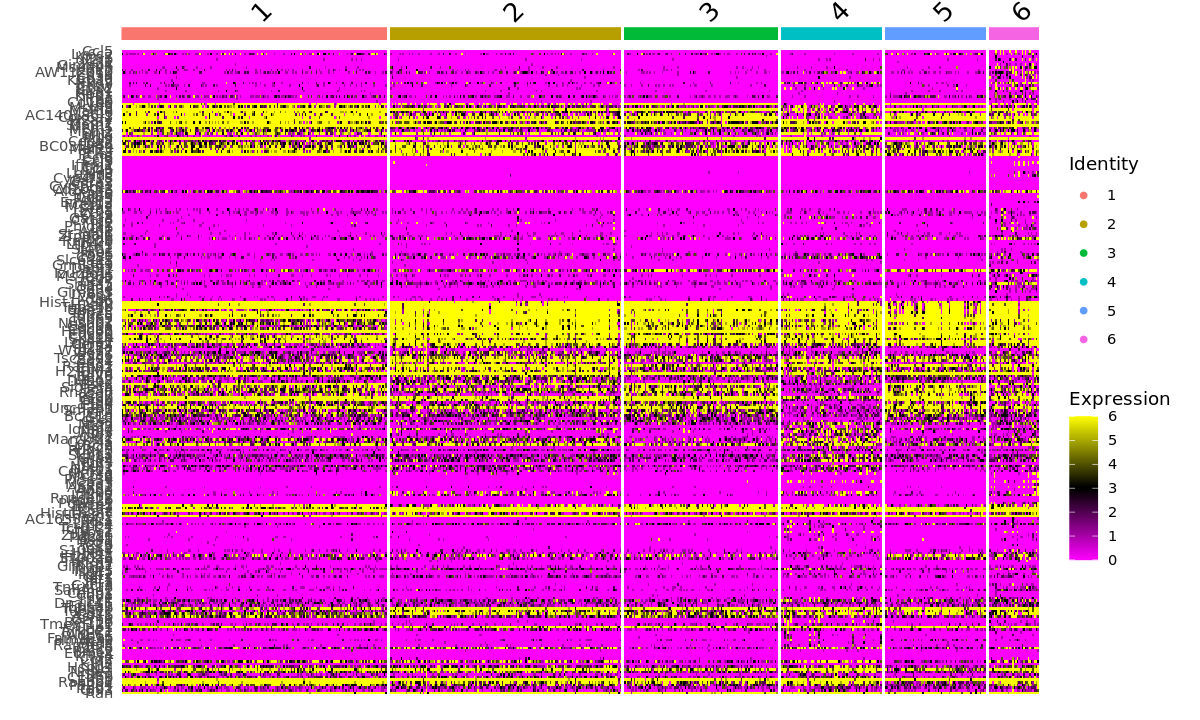

In [108]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [109]:
barcodes<-colnames(subset(seu, leiden_res.0.7=="6"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C6

In [110]:
seu <- seu_subsets[["6"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["6"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 4.982 sec elapsed


Computing nearest neighbor graph

Computing SNN



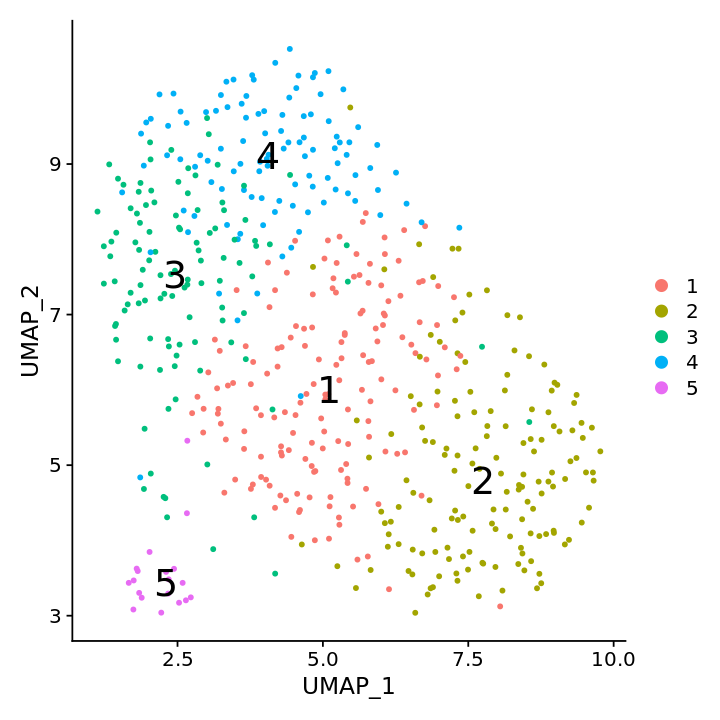

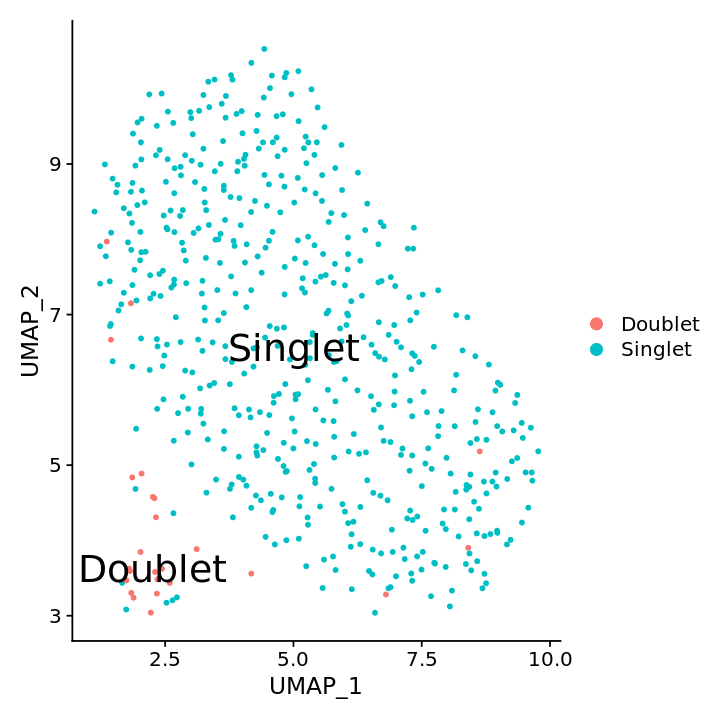

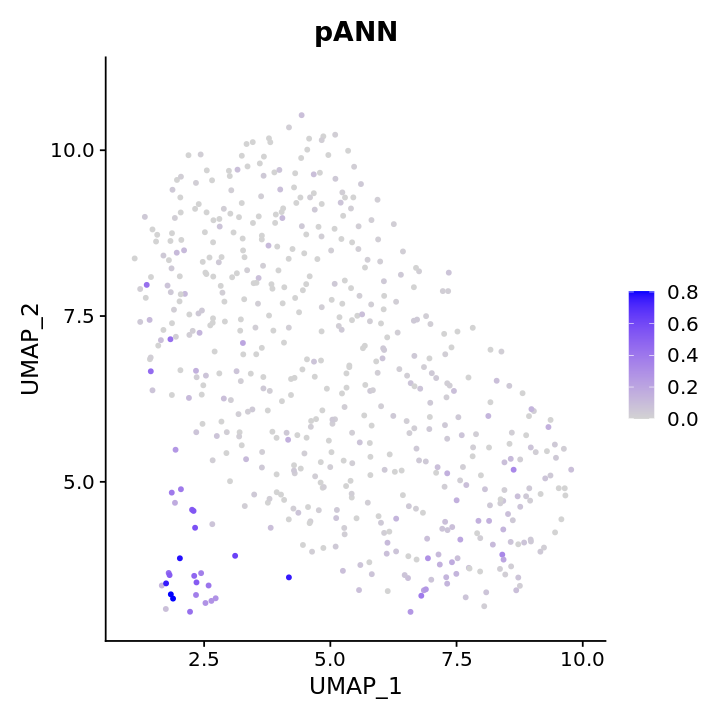

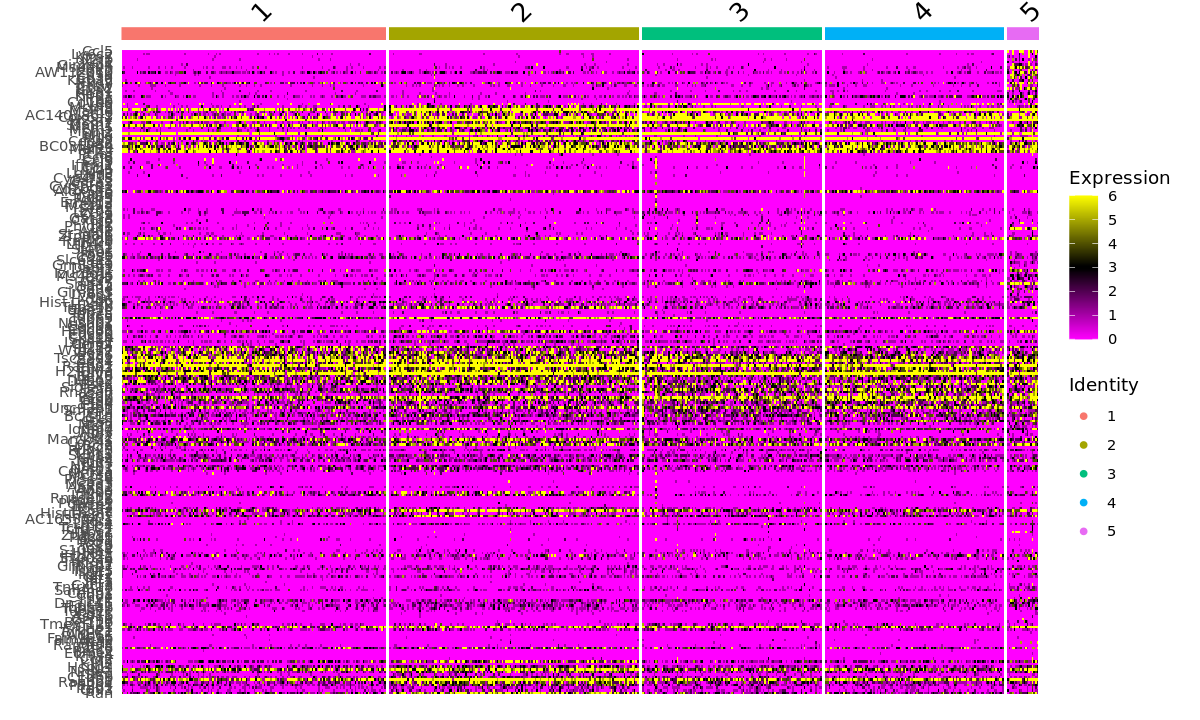

In [111]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [112]:
barcodes<-colnames(subset(seu, leiden_res.0.7=="5"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C7

In [113]:
seu <- seu_subsets[["7"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["7"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 4.71 sec elapsed


Computing nearest neighbor graph

Computing SNN



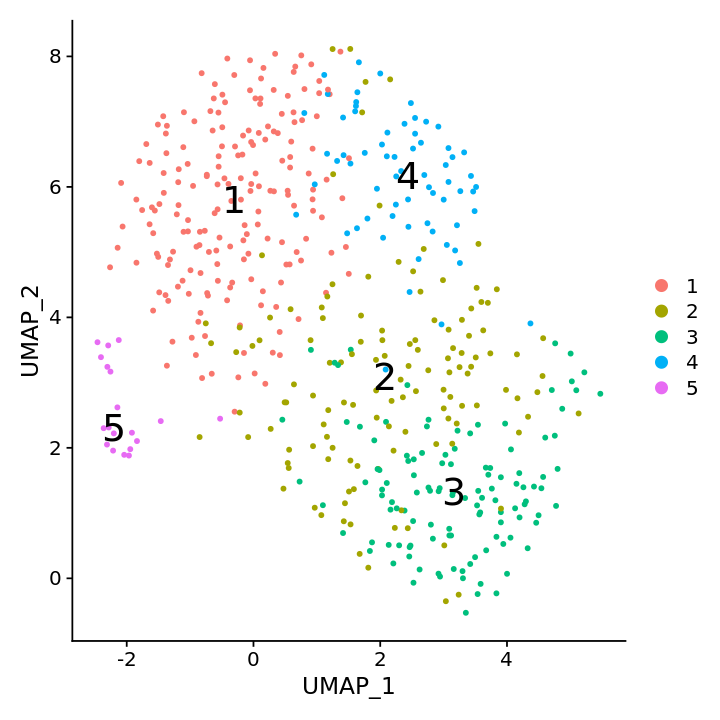

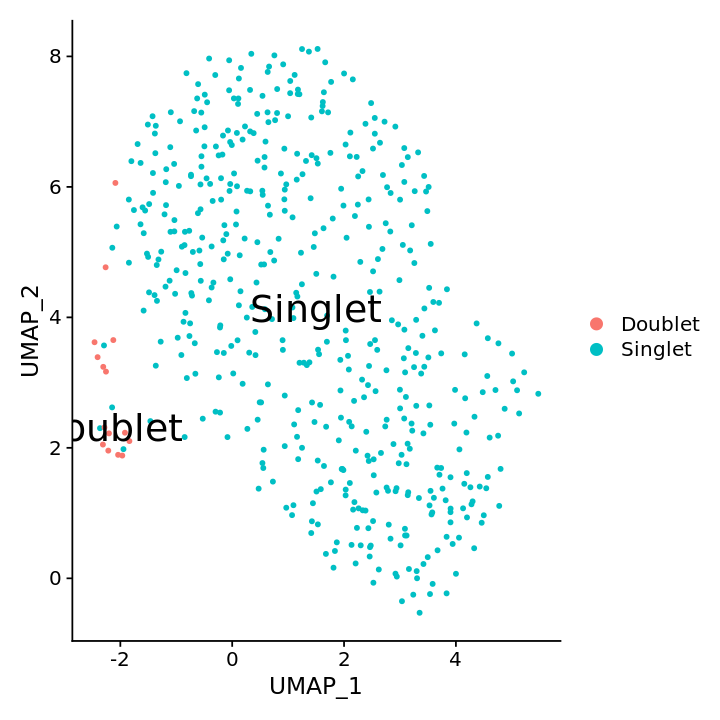

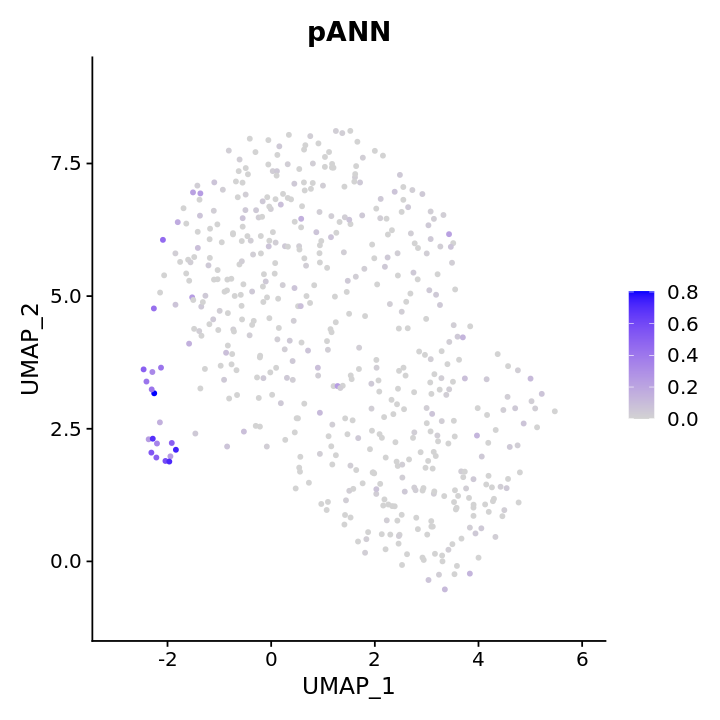

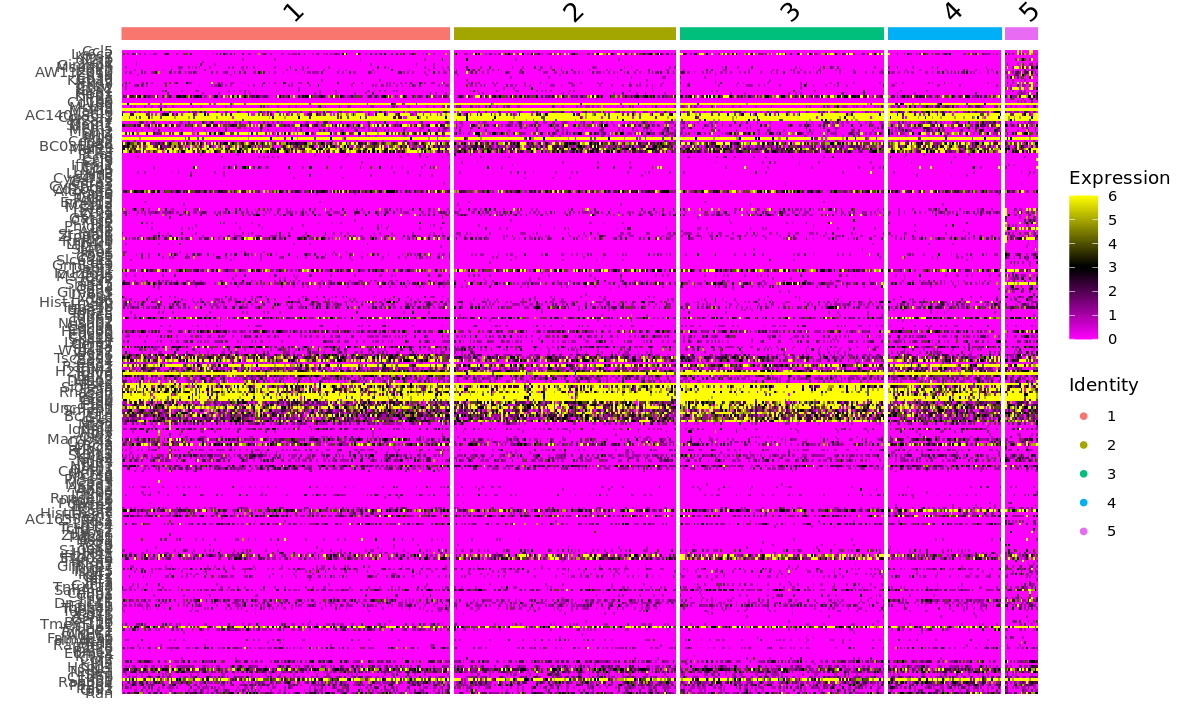

In [114]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [115]:
barcodes<-colnames(subset(seu, leiden_res.0.7=="5"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C8

In [116]:
seu <- seu_subsets[["8"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["8"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 4.527 sec elapsed


Computing nearest neighbor graph

Computing SNN



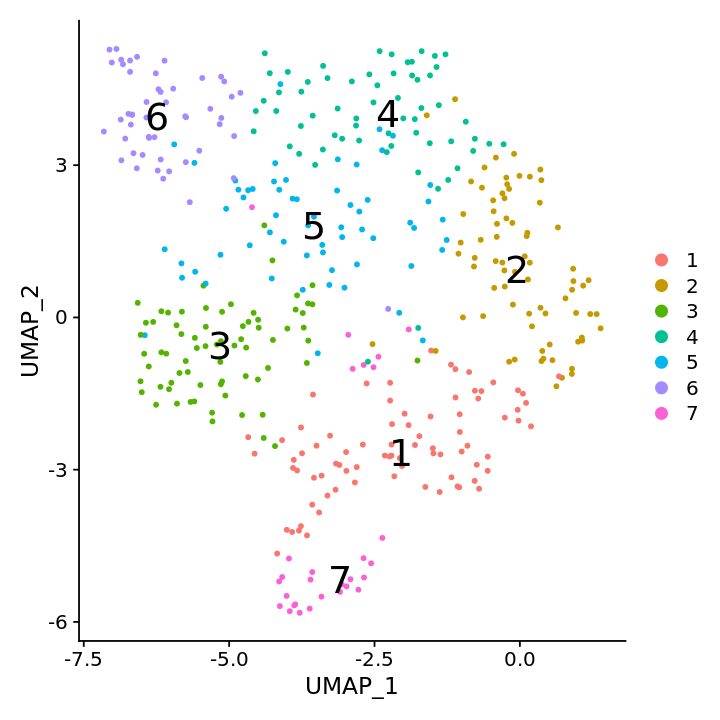

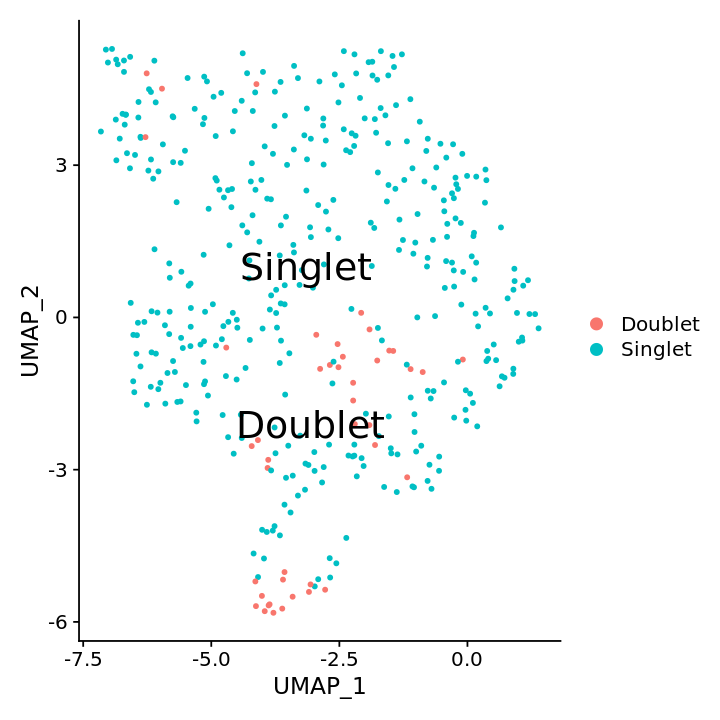

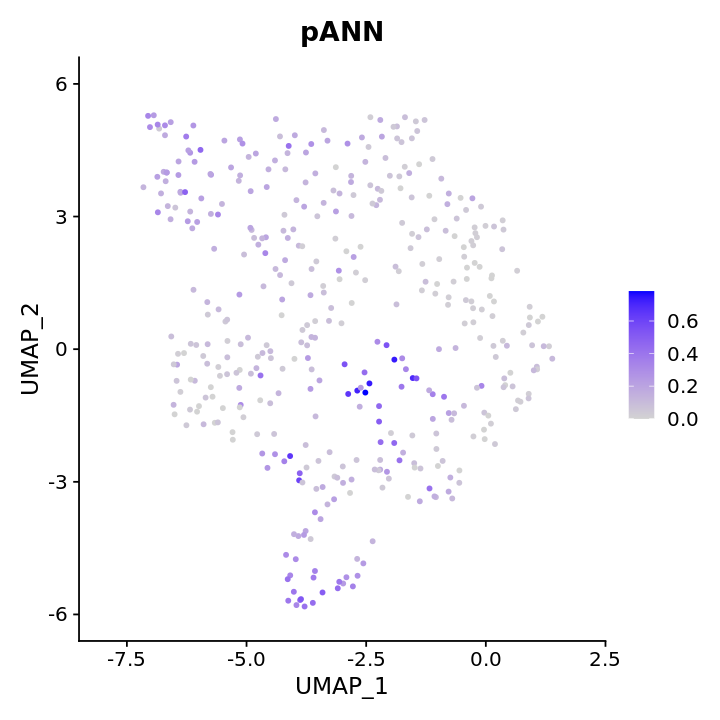

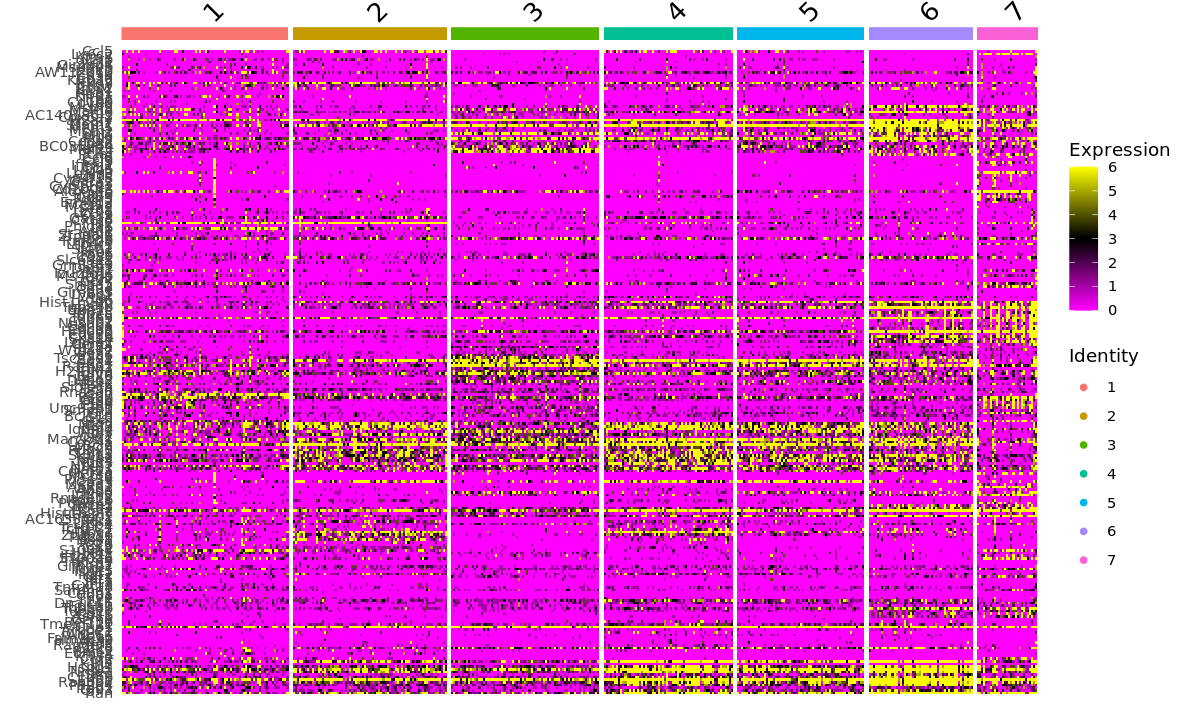

In [121]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [122]:
barcodes<-colnames(subset(seu, leiden_res.0.7=="7"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C11

In [123]:
seu <- seu_subsets[["11"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["11"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 3.81 sec elapsed


Computing nearest neighbor graph

Computing SNN



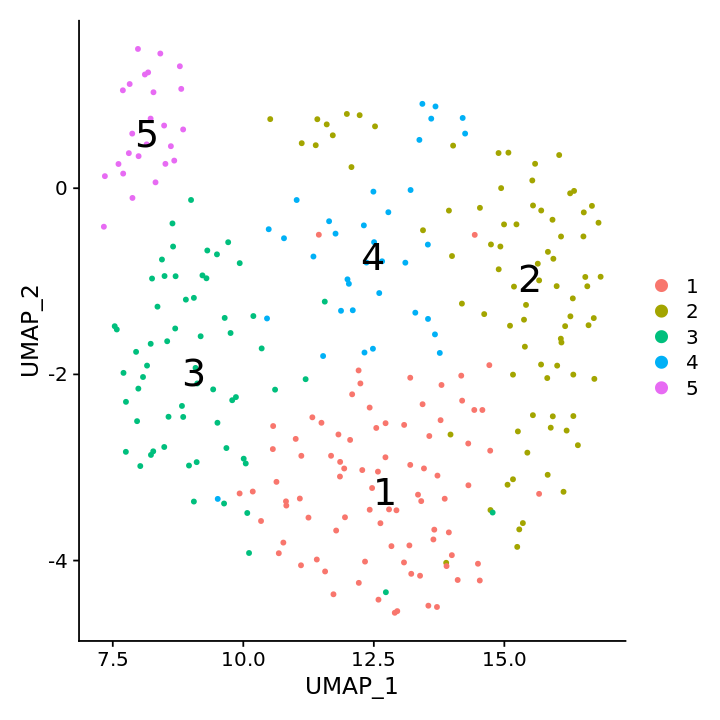

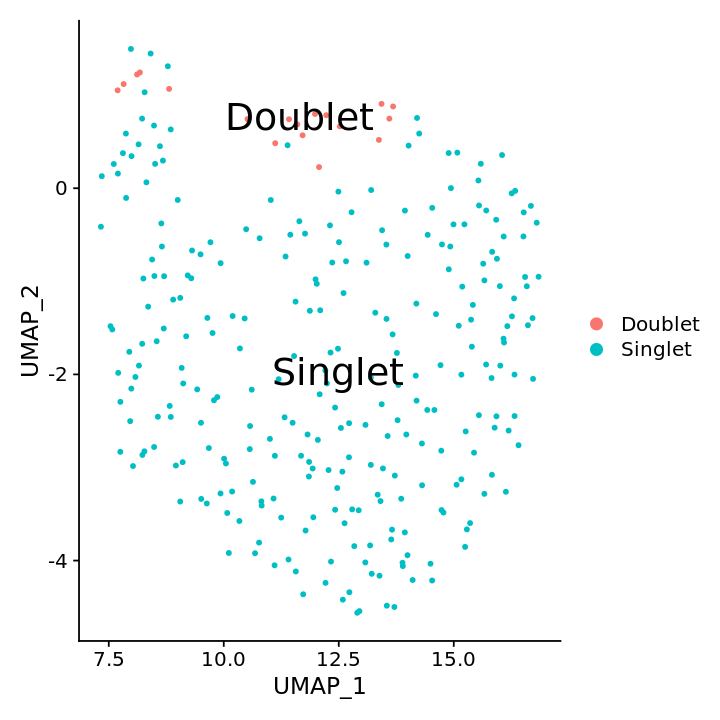

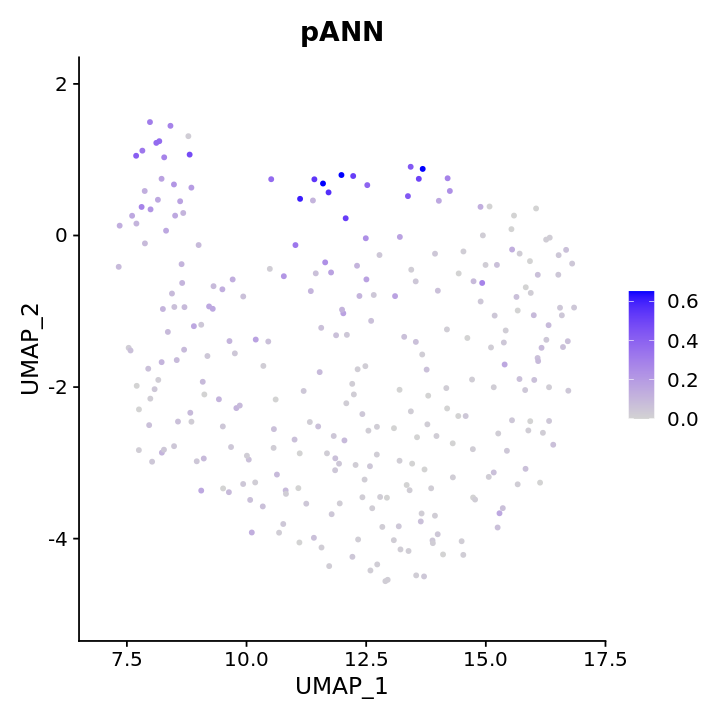

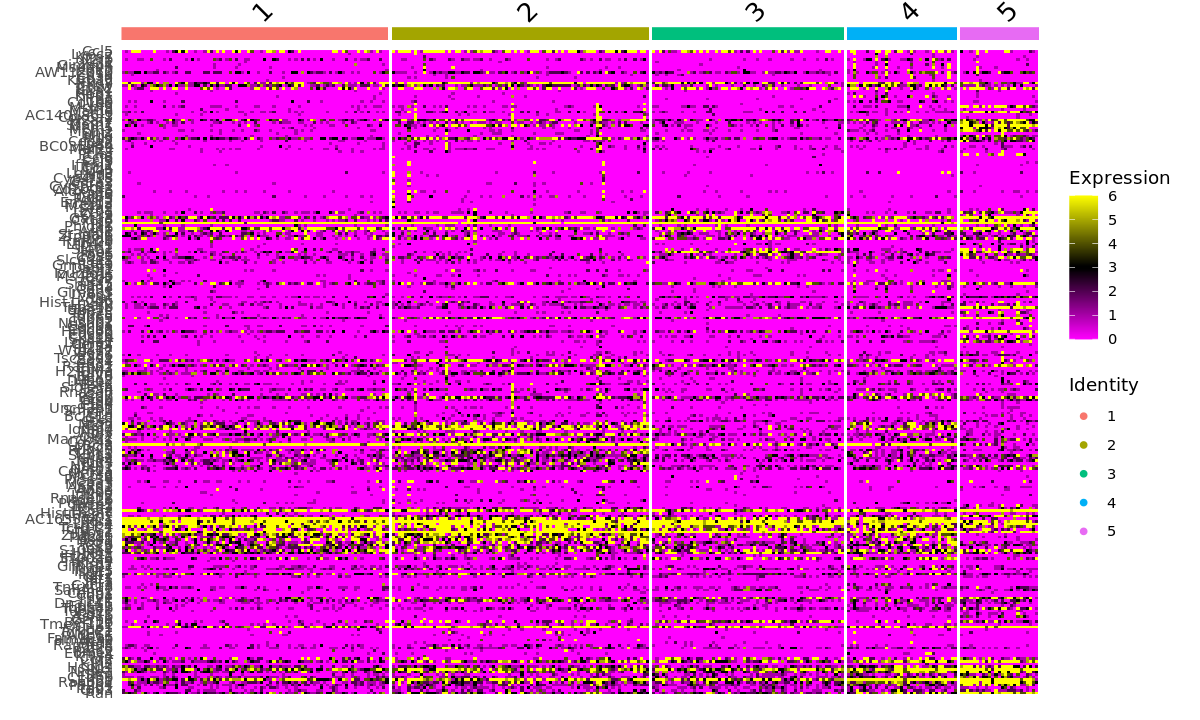

In [128]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [129]:
barcodes<-colnames(subset(seu, leiden_res.0.7=="5"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C14

In [131]:
seu <- seu_subsets[["14"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=20, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:20, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["14"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 2.465 sec elapsed


Computing nearest neighbor graph

Computing SNN



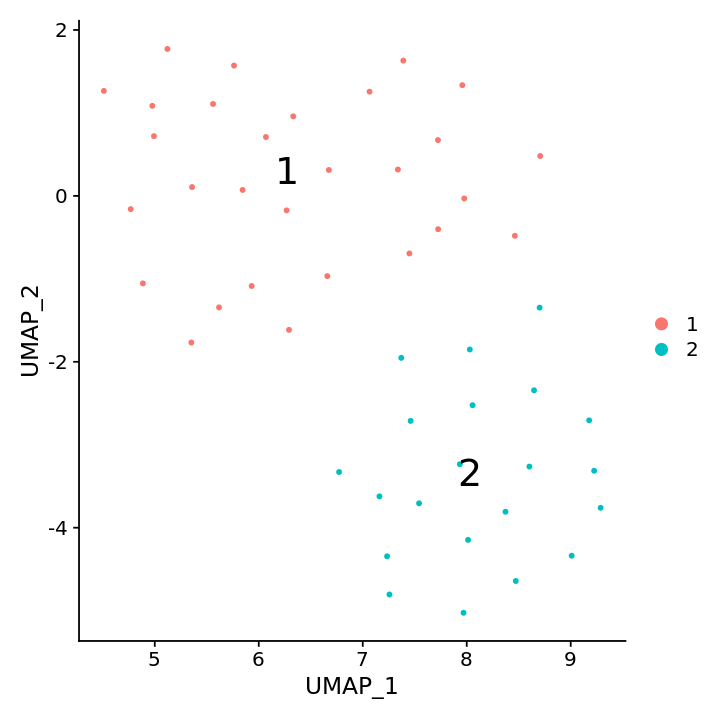

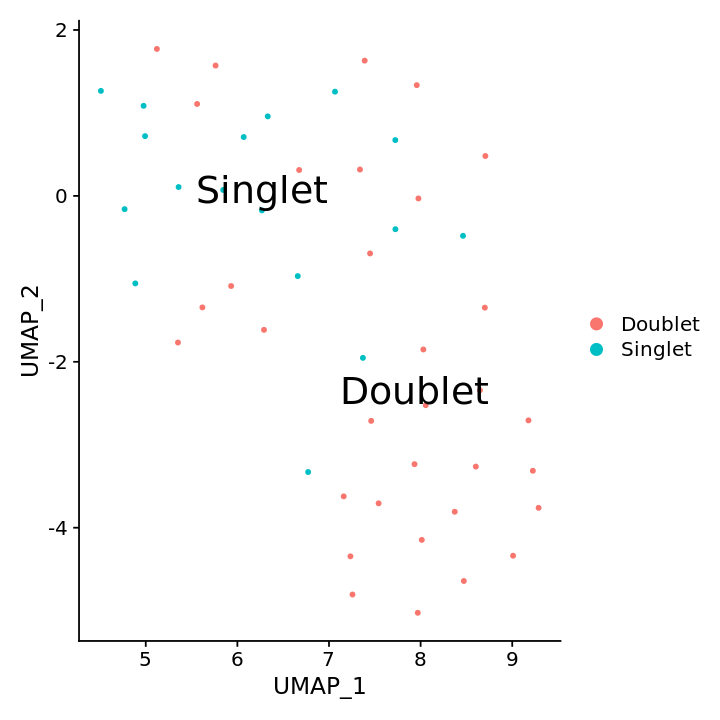

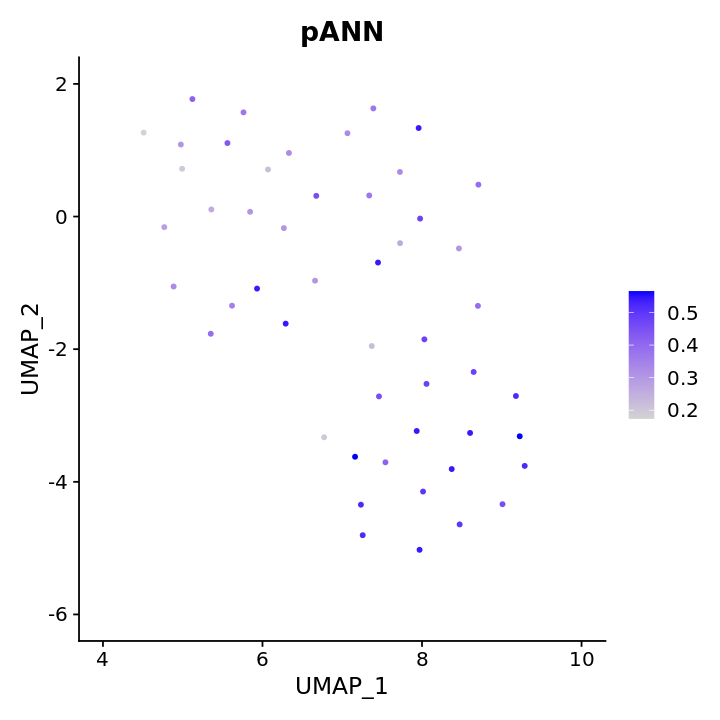

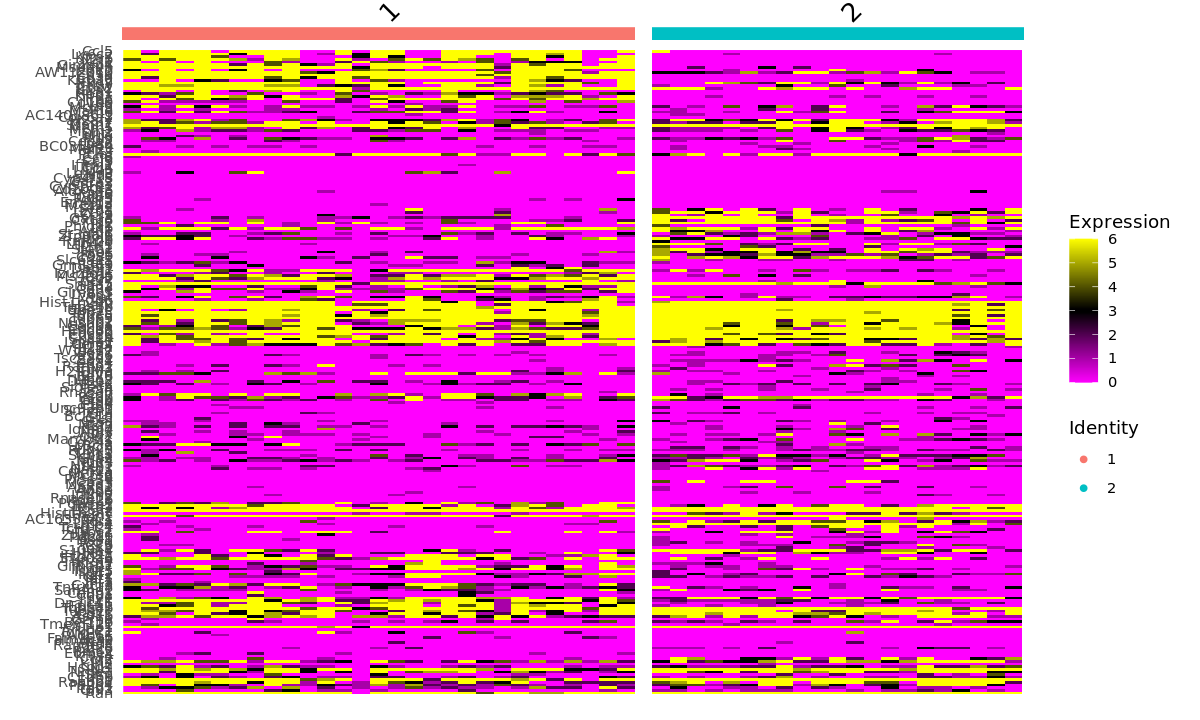

In [132]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [133]:
barcodes<-colnames(seu)
putative_doublets<-unique(c(putative_doublets, barcodes))

# C15

In [135]:
seu <- seu_subsets[["15"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=15, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:15, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["15"]]

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -1.3979”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.0979e-16”
Centering and scaling data matrix



Renormalization and Dimensionality reduction: 2.37 sec elapsed


Computing nearest neighbor graph

Computing SNN

1 singletons identified. 6 final clusters.



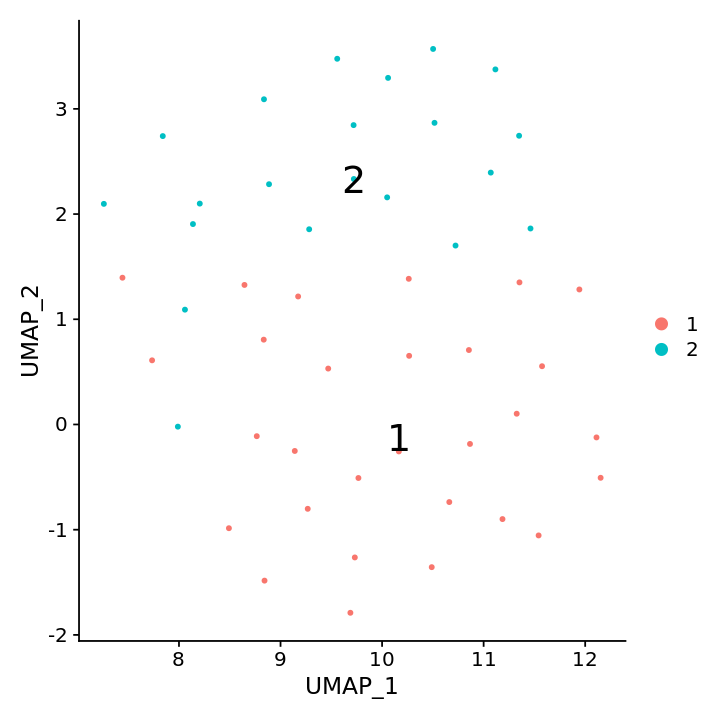

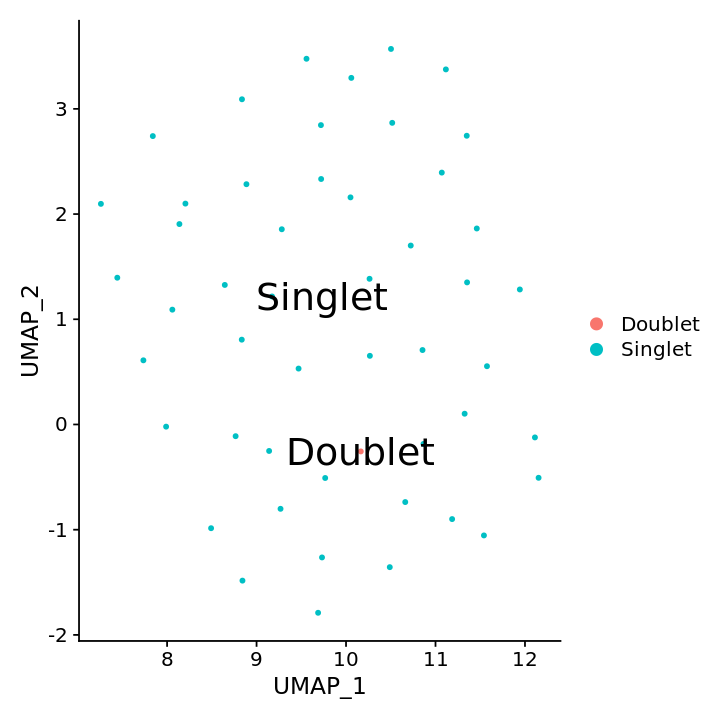

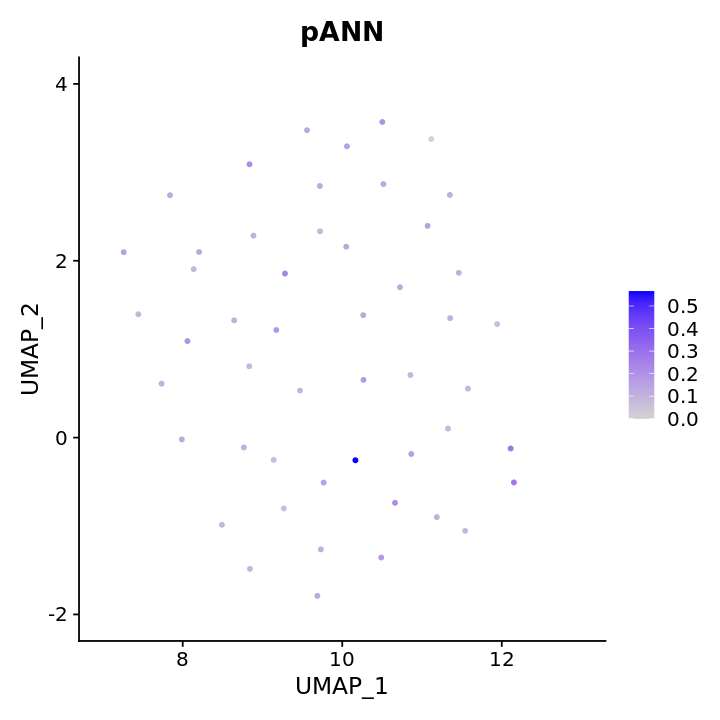

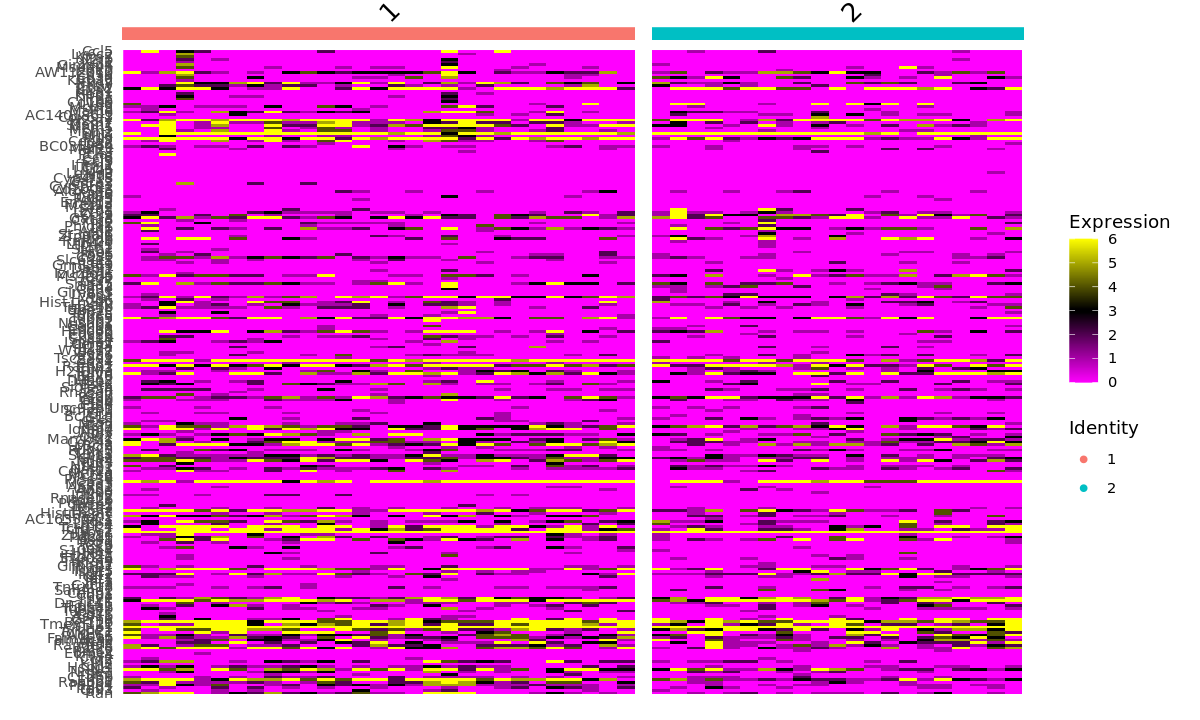

In [136]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [137]:
barcodes<-colnames(subset(seu,doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C16

In [138]:
seu <- seu_subsets[["16"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=15, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:15, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["16"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 2.586 sec elapsed


Computing nearest neighbor graph

Computing SNN

5 singletons identified. 5 final clusters.



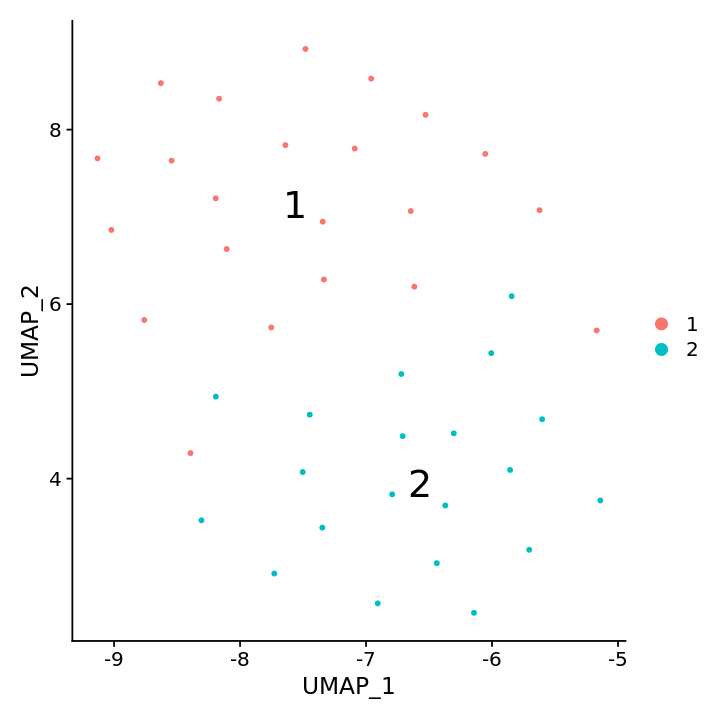

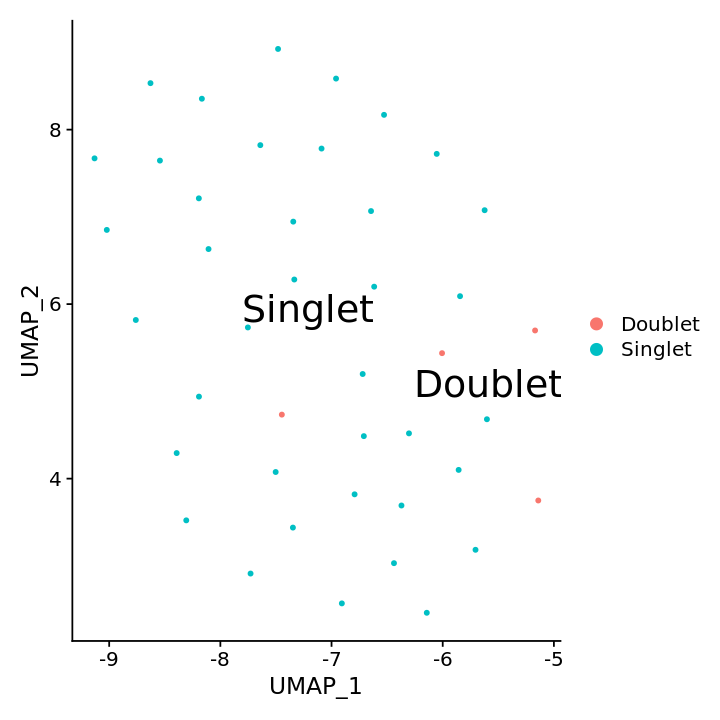

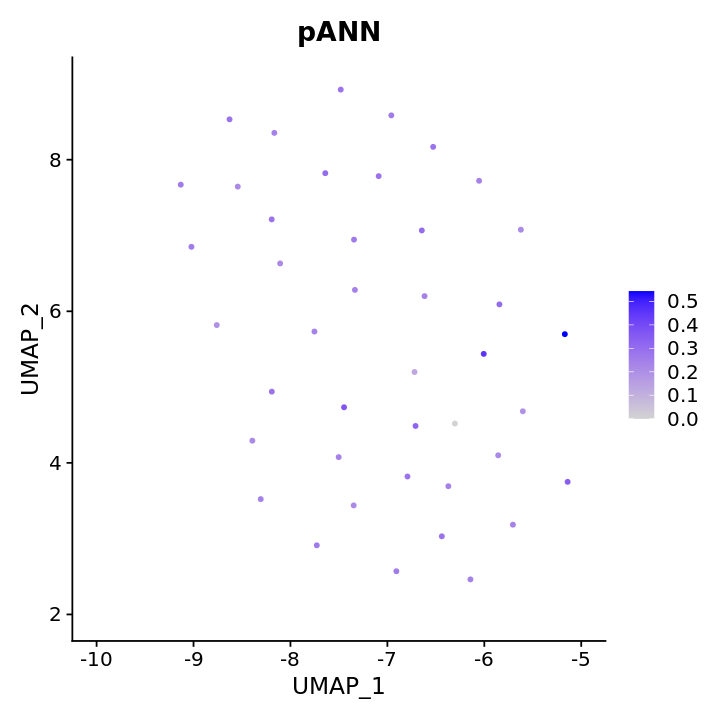

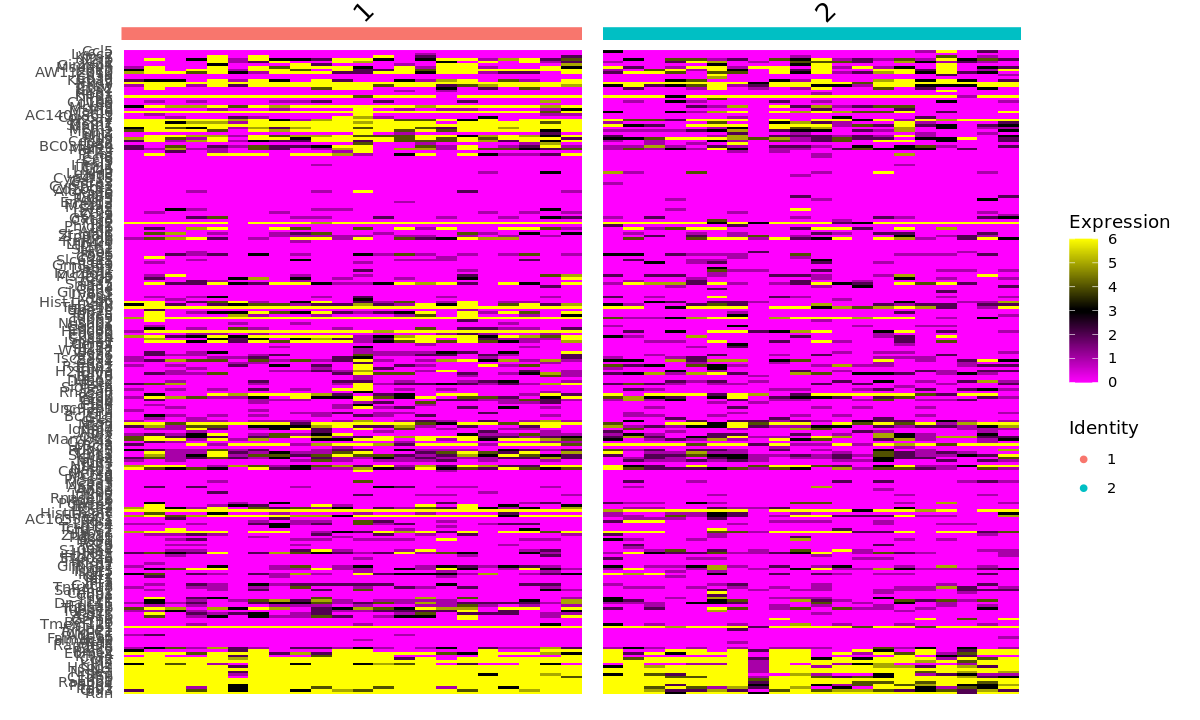

In [139]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [140]:
barcodes<-colnames(subset(seu,doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

In [143]:
length(putative_doublets)/ncol(seu.all)

[1] 0.04755728

In [ ]:
save(putative_doublets,file = "200220-ABMaLP2-PP1(multiplets).rda", compress=T)